# Supermarket marketing campaign

## Context

'All You Need' Supermarket is planning for the year-end sale.
They want to launch a new offer - gold membership for only \\$499 which is \\$999 on normal days(that gives a 20% discount on all purchases).

It will be valid only for existing customers, they are planning to start a campaign through phone calls.

The best way to reduce the cost of the campaign is to make a predictive model which will classify customers who might purchase the offer, using the data they gathered during last year’s campaign.

We will build a model for classifying whether customers will reply with a positive response or not.


## Objective
- What are the different factors which affect the target variable? What business recommendations can we give based on the analysis?
- How can we improve model performance using hyperparameter tuning and prevent data leakage using pipelines while building a model to predict the response of a customer?

### Data Description

- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
- ID - Unique ID of each customer
- Year_Birth - Age of the customer
- Complain - 1 if the customer complained in the last 2 years
- Dt_Customer - date of customer's enrollment with the company
- Education - customer's level of education
- Marital - customer's marital status
- Kidhome - number of small children in customer's household
- Teenhome - number of teenagers in customer's household
- Income - customer's yearly household income
- MntFishProducts - the amount spent on fish products in the last 2 years
- MntMeatProducts - the amount spent on meat products in the last 2 years
- MntFruits - the amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - the amount spent on wine products in the last 2 years
- MntGoldProds - the amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalog (buying goods to be shipped through the mail)
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through the company's website
- NumWebVisitsMonth - number of visits to company's website in the last month
- Recency - number of days since the last purchase

### Importing Libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

### Loading Data

In [2]:
jmd = pd.read_excel("marketing_data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
# Checking the number of rows and columns in the data
jmd.shape

(2240, 22)

<IPython.core.display.Javascript object>

* The dataset has 2240 rows and 22 columns 

## Data Overview

In [4]:
# let's create a copy of the data
data = jmd.copy()

<IPython.core.display.Javascript object>

In [5]:
# let's view the first 5 rows of the data
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.000,0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.000,0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.000,0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.000,1,1,2014-11-05 00:00:00,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.000,1,0,2014-08-04 00:00:00,0,6,16,24,11,0,34,2,3,1,2,7,1,0


<IPython.core.display.Javascript object>

In [6]:
# let's view the last 5 rows of the data
data.tail()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
2235,10142,1976,PhD,Divorced,66476.000,0,1,2013-07-03 00:00:00,99,372,18,126,47,48,78,2,5,2,11,4,0,0
2236,5263,1977,2n Cycle,Married,31056.000,1,0,1/22/13,99,5,10,13,3,8,16,1,1,0,3,8,0,0
2237,22,1976,Graduation,Divorced,46310.000,1,0,2012-03-12 00:00:00,99,185,2,88,15,5,14,2,6,1,5,8,0,0
2238,528,1978,Graduation,Married,65819.000,0,0,11/29/12,99,267,38,701,149,165,63,1,5,4,10,3,0,0
2239,4070,1969,PhD,Married,94871.000,0,2,2012-01-09 00:00:00,99,169,24,553,188,0,144,1,8,5,4,7,1,0


<IPython.core.display.Javascript object>

In [7]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

<IPython.core.display.Javascript object>

- There are a total of 22 columns and 2,240 observations in the dataset
- We can see that income column have less than 2,240 non-null values i.e. column have missing values. We'll explore this further.

In [8]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [9]:
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

ID                    0.000
Year_Birth            0.000
Education             0.000
Marital_Status        0.000
Income                1.070
Kidhome               0.000
Teenhome              0.000
Dt_Customer           0.000
Recency               0.000
MntWines              0.000
MntFruits             0.000
MntMeatProducts       0.000
MntFishProducts       0.000
MntSweetProducts      0.000
MntGoldProds          0.000
NumDealsPurchases     0.000
NumWebPurchases       0.000
NumCatalogPurchases   0.000
NumStorePurchases     0.000
NumWebVisitsMonth     0.000
Response              0.000
Complain              0.000
dtype: float64

<IPython.core.display.Javascript object>

- Income column has 1.07% missing values

In [10]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.000,5592.160,3246.662,0.000,2828.250,5458.500,8427.750,11191.000
Year_Birth,2240.000,1968.806,11.984,1893.000,1959.000,1970.000,1977.000,1996.000
Income,2216.000,52247.251,25173.077,1730.000,35303.000,51381.500,68522.000,666666.000
Kidhome,2240.000,0.444,0.538,0.000,0.000,0.000,1.000,2.000
Teenhome,2240.000,0.506,0.545,0.000,0.000,0.000,1.000,2.000
Recency,2240.000,49.109,28.962,0.000,24.000,49.000,74.000,99.000
MntWines,2240.000,303.936,336.597,0.000,23.750,173.500,504.250,1493.000
MntFruits,2240.000,26.302,39.773,0.000,1.000,8.000,33.000,199.000
MntMeatProducts,2240.000,166.950,225.715,0.000,16.000,67.000,232.000,1725.000
MntFishProducts,2240.000,37.525,54.629,0.000,3.000,12.000,50.000,259.000


<IPython.core.display.Javascript object>

**Observations:**
- `Year_Birth` has a large range of values i.e. 1893 to 1996. 
- The birth year <=1900 is some users, while the year of campaign we are considering is 2016. It's very unlikely that the person is alive. It may be a reporting error. We will explore this further.
- Income has a max value of 666666 which is far greater than the mean and could be an outlier.
- Columns - `Income, MntFruits, MntWines, MntMeatProducts, MntFishProducts, MntSweetProducts` might have outliers on the right end as there is a large difference between 75th percentile and maximum values.
- Recency has an approx equal mean and median which is equal to 49 days.
- Highest mean amount spent per customer in the last two years is on wines (approx 304), followed by meat products (approx 167).

## Data Preprocessing

- We can drop the column - `ID` as it is unique for each customer and will not add value to the model.

In [11]:
# Dropping column - ID
data.drop(columns=["ID"], inplace=True)

<IPython.core.display.Javascript object>

**Adding age of the customers to the data using given birth years**

In [12]:
# To calculate age we'll subtract the year 2016 because variables account for the last 2 years
# and we have customers registered till 2014 only
# We need to convert strings values to dates first to use subtraction
data["Age"] = 2016 - pd.to_datetime(data["Year_Birth"], format="%Y").apply(
    lambda x: x.year
)

data["Age"].sort_values()

562      20
1824     20
697      21
1468     21
964      21
       ... 
1740     75
2171     76
2233    116
827     117
513     123
Name: Age, Length: 2240, dtype: int64

<IPython.core.display.Javascript object>

- We can see that there are 3 observations with ages greater than 100 i.e. 116, 117 and 123 which is highly unlikely to be true.
- We can drop the observations with age greater than 100

In [13]:
data[data["Age"] > 100]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age
513,1893,2n Cycle,Single,60182.000,0,1,5/17/14,23,8,0,5,7,0,2,1,1,0,2,4,0,0,123
827,1899,PhD,Together,83532.000,0,0,9/26/13,36,755,144,562,104,64,224,1,4,6,4,1,0,0,117
2233,1900,2n Cycle,Divorced,36640.000,1,0,9/26/13,99,15,6,8,7,4,25,1,2,1,2,5,0,1,116


<IPython.core.display.Javascript object>

- The Year_Birth for these 3 observations seems to be incorrect
- Replacing them with some other values might not be the best thing to do
- We will drop these 3 observations

In [14]:
# Dropping the 3 observations with age > 100
data.drop(data[data["Age"] > 100].index, inplace=True)

<IPython.core.display.Javascript object>

**Using Dt_Customer to add features to the data**

In [15]:
# The feature Dt_Customer represents dates of the customer’s enrollment with the company.
# Let's convert this to DateTime format
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])

<IPython.core.display.Javascript object>

In [16]:
# Extracting registration year from the date
data["Reg_year"] = data["Dt_Customer"].apply(lambda x: x.year)

# Extracting registration quarter from the date
data["Reg_quarter"] = data["Dt_Customer"].apply(lambda x: x.quarter)

# Extracting registration month from the date
data["Reg_month"] = data["Dt_Customer"].apply(lambda x: x.month)

# Extracting registration week from the date
data["Reg_week"] = data["Dt_Customer"].apply(lambda x: x.day // 7)

<IPython.core.display.Javascript object>

In [17]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week
0,1970,Graduation,Divorced,84835.000,0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,1,0,46,2014,2,6,2
1,1961,Graduation,Single,57091.000,0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,1,0,55,2014,2,6,2
2,1958,Graduation,Married,67267.000,0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,58,2014,2,5,1
3,1967,Graduation,Together,32474.000,1,1,2014-11-05,0,10,0,1,0,0,0,1,1,0,2,7,0,0,49,2014,4,11,0
4,1989,Graduation,Single,21474.000,1,0,2014-08-04,0,6,16,24,11,0,34,2,3,1,2,7,1,0,27,2014,3,8,0


<IPython.core.display.Javascript object>

**Let's check the count of each unique category in each of the categorical variables.** 

In [18]:
# Making a list of all categorical variables
cat_col = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "Complain",
    "Response",
    "Reg_year",
    "Reg_quarter",
    "Reg_month",
    "Reg_week",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

Graduation    1127
PhD            485
Master         370
2n Cycle       201
Basic           54
Name: Education, dtype: int64
----------------------------------------
Married     864
Together    579
Single      479
Divorced    231
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
----------------------------------------
0    1291
1     898
2      48
Name: Kidhome, dtype: int64
----------------------------------------
0    1156
1    1029
2      52
Name: Teenhome, dtype: int64
----------------------------------------
0    2217
1      20
Name: Complain, dtype: int64
----------------------------------------
0    1903
1     334
Name: Response, dtype: int64
----------------------------------------
2013    1187
2014     556
2012     494
Name: Reg_year, dtype: int64
----------------------------------------
4    596
1    580
2    545
3    516
Name: Reg_quarter, dtype: int64
----------------------------------------
8     211
10    209
12    202
3  

<IPython.core.display.Javascript object>

- In education, 2n cycle and Master means the same thing. We can combine these two categories.
- There are many categories in marital status. We can combine the categories 'Alone', 'Absurd' and 'YOLO' with 'Single' and 'Together' categories with 'Married'.
- There are only 21 customers who complained in the last two years.
- We have 1906 observations for the 0 class but only 334 observations for class 1.
- There are only three years in the customer registration data.

In [19]:
# Replacing 2n Cycle with Master
data["Education"] = data["Education"].replace("2n Cycle", "Master")

<IPython.core.display.Javascript object>

In [20]:
# Replacing YOLO, Alone, Absurd with single and Together with Married
data["Marital_Status"] = data["Marital_Status"].replace(
    ["YOLO", "Alone", "Absurd"], "Single"
)
data["Marital_Status"] = data["Marital_Status"].replace(["Together"], "Married")

<IPython.core.display.Javascript object>

**We can add a column - total amount spent by each customer in the last 2 years**

In [21]:
data["Total_Amount_Spent"] = data[
    [
        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds",
    ]
].sum(axis=1)

<IPython.core.display.Javascript object>

## EDA

### Univariate

In [22]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

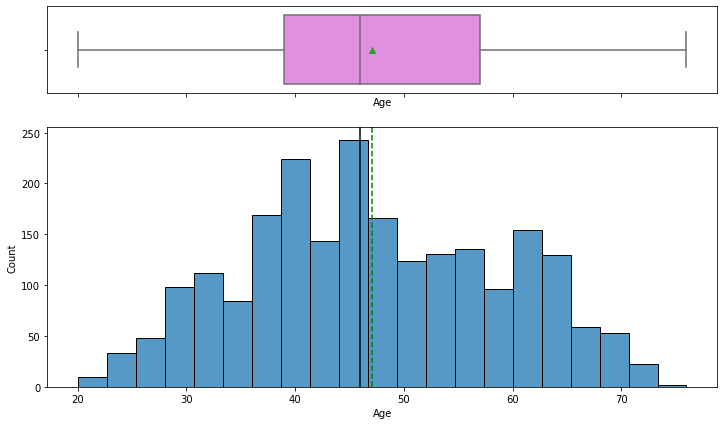

<IPython.core.display.Javascript object>

In [23]:
# Observations on Customer_age
histogram_boxplot(data, "Age")

- As per the boxplot, there are no outliers in the 'Age' variable
- Age has a fairly normal distribution with approx equal mean and median

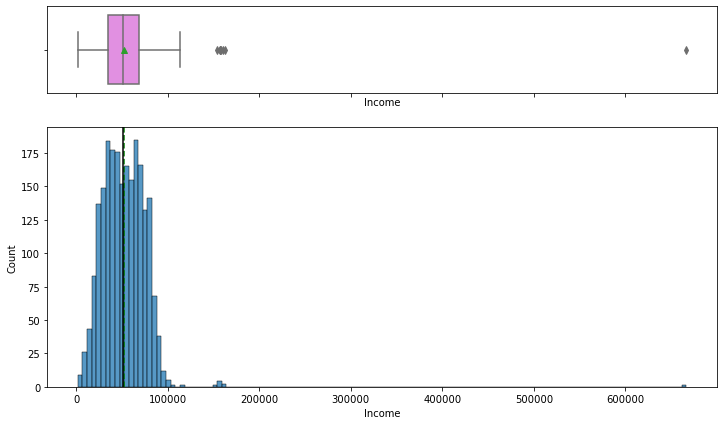

<IPython.core.display.Javascript object>

In [24]:
# observations on Income
histogram_boxplot(data, "Income")

- We can see there are some outliers in the income variable.
- Some variation is always expected in real-world scenarios for the income variable but we can remove the data point on the extreme right end of the boxplot as it can be a data entry error.

In [25]:
data[data["Income"] > 200000]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
527,1977,Graduation,Married,666666.000,1,0,2013-02-06,23,9,14,18,8,1,12,4,3,1,3,6,0,0,39,2013,1,2,0,62


<IPython.core.display.Javascript object>

In [26]:
# Dropping observaion with income greater than 20000. Since there is just 1 such observation
data.drop(index=data[data.Income > 200000].index, inplace=True)

<IPython.core.display.Javascript object>

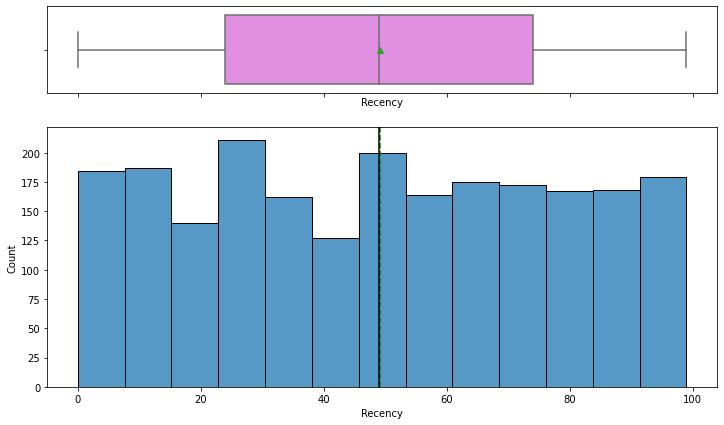

<IPython.core.display.Javascript object>

In [27]:
# observations on Recency
histogram_boxplot(data, "Recency")

- There are no outliers in the 'Recency' variable
- The distribution is fairly symmetric and uniformly distributed.

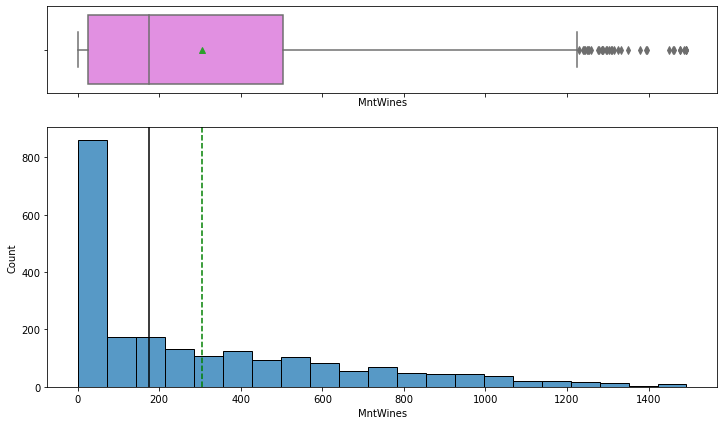

<IPython.core.display.Javascript object>

In [28]:
# observations on MntWines
histogram_boxplot(data, "MntWines")

- The distribution for the amount spent on wines is highly skewed to the right
- As the median of the distribution is less than 200, more than 50% of customers have spent less than 200 on wines.
- There are some outliers on the right end of the boxplot but we will not treat them as some variation is always expected in real-world scenarios for variables like amount spent.

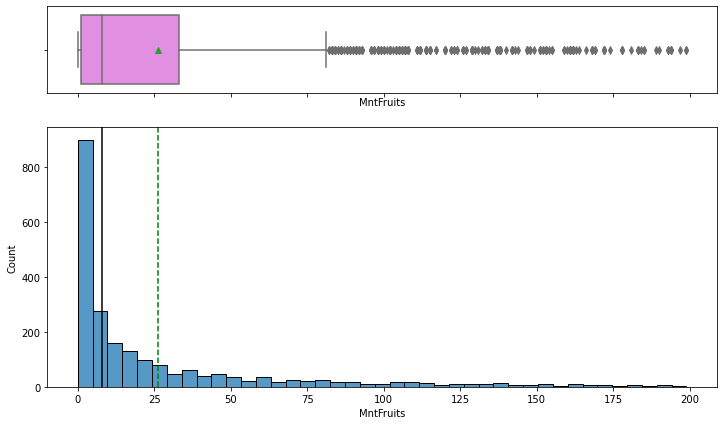

<IPython.core.display.Javascript object>

In [29]:
# observations on MntFruits
histogram_boxplot(data, "MntFruits")

- The distribution for the amount spent on fruits is highly skewed to the right.
- As the median of the distribution is less than 20, more than 50% of customers have spent less than 20 on fruits.
- There are some outliers on the right end of the boxplot but we will not treat them as some variation is always expected in real-world scenarios for variables like amount spent.

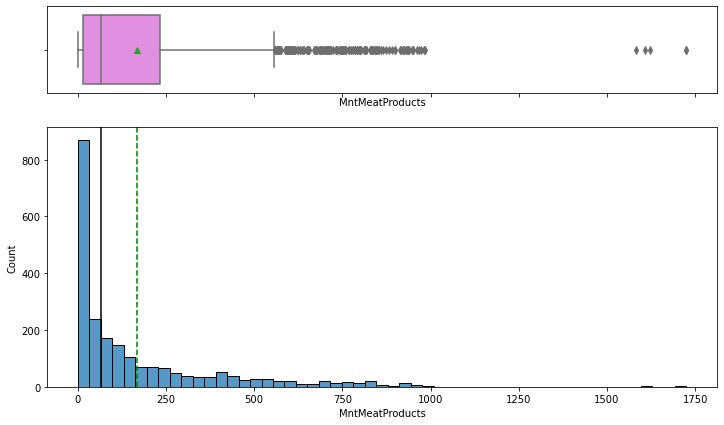

<IPython.core.display.Javascript object>

In [30]:
# observations on MntMeatProducts
histogram_boxplot(data, "MntMeatProducts")

- The distribution for the amount spent on meat products is highly skewed to the right.
- We can see that there are some extreme observations in the variable that can be considered as outliers as they very far from the rest of the values. 
- We can cap the value of the variable to the next highest value.

In [31]:
# Checking 10 largest values of amount spend on meat products
data.MntMeatProducts.nlargest(10)

325     1725
961     1725
497     1622
1213    1607
2204    1582
1921     984
53       981
994      974
2021     968
1338     961
Name: MntMeatProducts, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
data[data["MntMeatProducts"] > 1580]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
325,1977,Graduation,Married,157146.000,0,0,2013-04-29,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,39,2013,2,4,4,1730
497,1982,PhD,Married,160803.000,0,0,2012-04-08,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,34,2012,2,4,1,1717
961,1979,Graduation,Married,2447.000,1,0,2013-06-01,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,37,2013,2,6,0,1730
1213,1978,Master,Married,NaN,0,0,2012-12-08,53,32,2,1607,12,4,22,0,0,0,1,0,0,0,38,2012,4,12,1,1679
2204,1973,PhD,Married,157243.000,0,1,2014-01-03,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,43,2014,1,1,0,1608


<IPython.core.display.Javascript object>

- The values for MntMeatProducts for these 5 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [33]:
# Capping values for amount spent on meat products at next highest value i.e. 984
data["MntMeatProducts"].clip(upper=984, inplace=True)

<IPython.core.display.Javascript object>

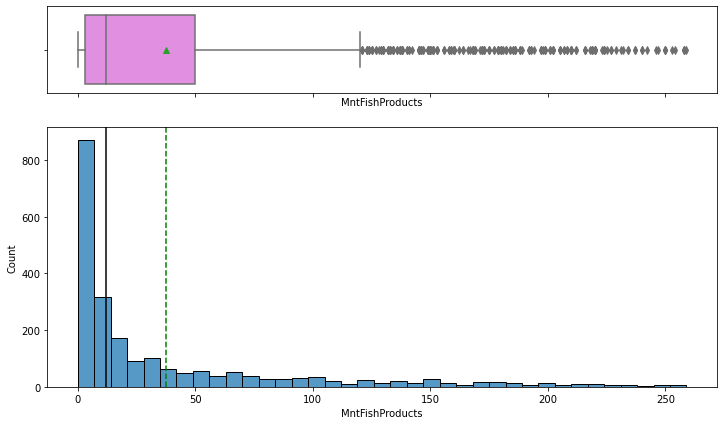

<IPython.core.display.Javascript object>

In [34]:
# observations on MntFishProducts
histogram_boxplot(data, "MntFishProducts")

- The distribution for the amount spent on fish products is right-skewed
- There are some outliers on the right end in the boxplot but we will not treat them as this represents a real market trend that some customers spend more on fish products than others.

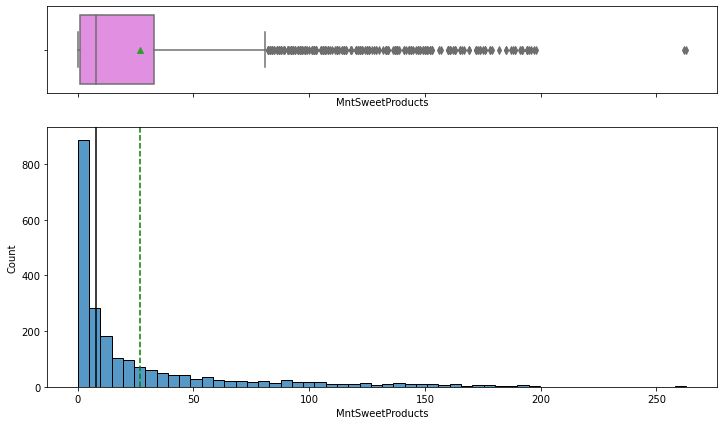

<IPython.core.display.Javascript object>

In [35]:
# observations on MntSweetProducts
histogram_boxplot(data, "MntSweetProducts")

- The distribution for the amount spent on sweet products is right-skewed 
- There is one observation to the right extreme which can be considered as an outlier. 
- We will not remove all such data points as they represent real market trends but we can cap some of the extreme values.

In [36]:
data[data["MntSweetProducts"] > 200]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
210,1945,PhD,Single,113734.000,0,0,2014-05-28,9,6,2,3,1,262,3,0,27,0,0,1,0,0,71,2014,2,5,4,277
449,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,263,362,0,27,0,0,1,0,0,30,2013,1,2,2,637


<IPython.core.display.Javascript object>

- The values for MntSweetProducts for these 2 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [37]:
# Capping values for amount spent on sweet products at 198
data["MntSweetProducts"].clip(upper=198, inplace=True)

<IPython.core.display.Javascript object>

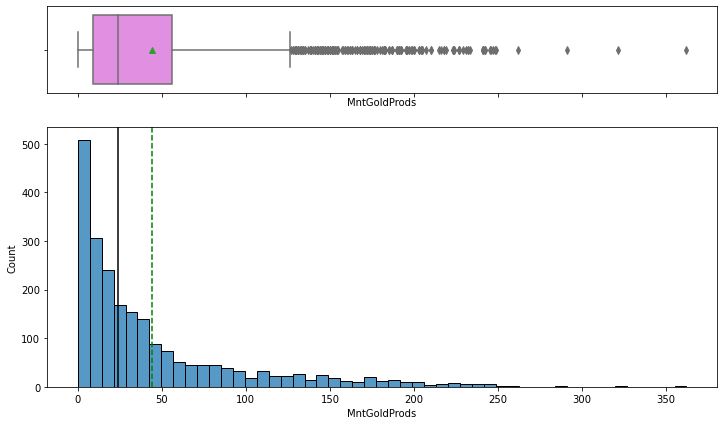

<IPython.core.display.Javascript object>

In [38]:
# observations on MntGoldProds
histogram_boxplot(data, "MntGoldProds")

- The distribution for the amount spent on gold products is right-skewed 
- There are some outliers in the amount spent on gold products. We will not remove all such data points as they represent real market trends but we can cap some of the extreme values.

In [39]:
data[data["MntGoldProds"] > 250]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
14,1969,Graduation,Married,4428.000,0,1,2013-05-10,0,16,4,12,2,4,321,0,25,0,0,1,0,0,47,2013,2,5,1,359
60,1982,Master,Single,6560.000,0,0,2013-12-12,2,67,11,26,4,3,262,0,1,0,1,17,0,0,34,2013,4,12,1,373
449,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,198,362,0,27,0,0,1,0,0,30,2013,1,2,2,637
2063,1966,PhD,Single,7144.000,0,2,2013-07-12,92,81,4,33,5,2,291,0,23,1,1,0,0,0,50,2013,3,7,1,416


<IPython.core.display.Javascript object>

- The values for MntGoldProds for these 4 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [40]:
# Capping values for amount spent on gold products at 250
data["MntGoldProds"].clip(upper=250, inplace=True)

<IPython.core.display.Javascript object>

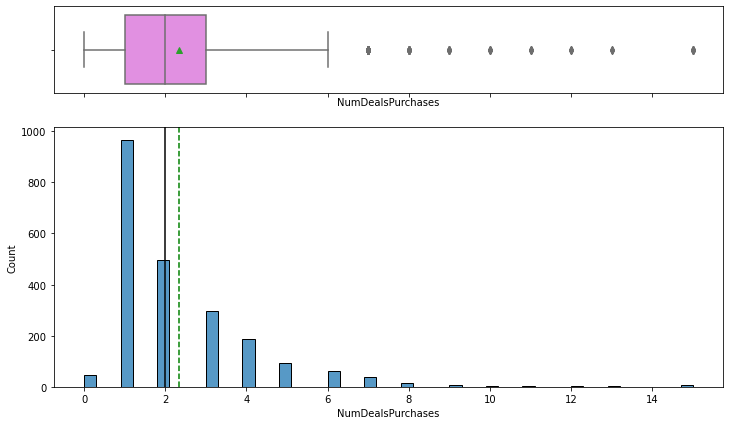

<IPython.core.display.Javascript object>

In [41]:
# observations on NumDealsPurchases
histogram_boxplot(data, "NumDealsPurchases")

- Majority of the customers have 2 or less than 2 deal purchases. 
- We can see that there some extreme observations in the variable. This represents the real market trend.

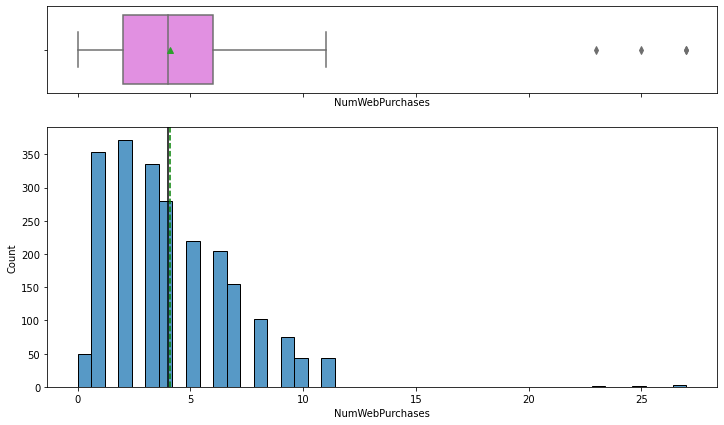

<IPython.core.display.Javascript object>

In [42]:
# observations on NumWebPurchases
histogram_boxplot(data, "NumWebPurchases")

- The median of the distribution is 4 i.e. 50% of customers have 4 or less than 4 web purchases. 
- We can see that there are some extreme observations in the variable. We can cap these values to the next highest number of purchases.

In [43]:
data[data["NumWebPurchases"] > 15]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
14,1969,Graduation,Married,4428.000,0,1,2013-05-10,0,16,4,12,2,4,250,0,25,0,0,1,0,0,47,2013,2,5,1,359
210,1945,PhD,Single,113734.000,0,0,2014-05-28,9,6,2,3,1,198,3,0,27,0,0,1,0,0,71,2014,2,5,4,277
449,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,198,250,0,27,0,0,1,0,0,30,2013,1,2,2,637
2063,1966,PhD,Single,7144.000,0,2,2013-07-12,92,81,4,33,5,2,250,0,23,1,1,0,0,0,50,2013,3,7,1,416


<IPython.core.display.Javascript object>

- The values for NumWebPurchases for these 4 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [44]:
# Capping values for number of web purchases at 11
data["NumWebPurchases"].clip(upper=11, inplace=True)

<IPython.core.display.Javascript object>

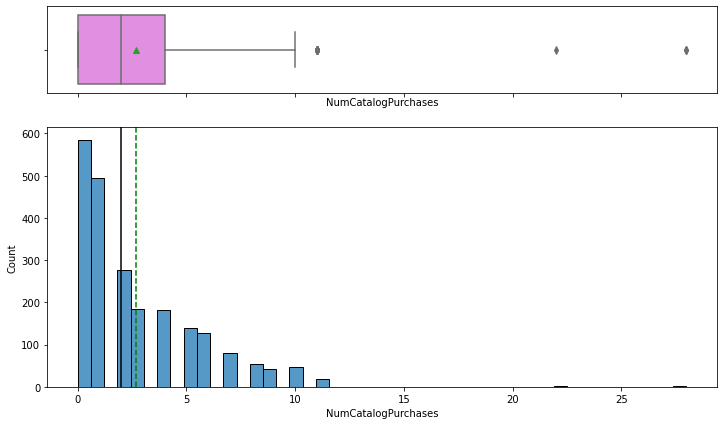

<IPython.core.display.Javascript object>

In [45]:
# observations on NumCatalogPurchases
histogram_boxplot(data, "NumCatalogPurchases")

- The most number of observations are for 0 catalog purchases.
- The median of the distribution is 2 i.e. 50% of customers have 2 or less than 2 catalog purchases. 
- We can see that there is two extreme observation in the variable. We can cap these values to the next highest number of purchases.

In [46]:
data[data["NumCatalogPurchases"] > 15]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week,Total_Amount_Spent
325,1977,Graduation,Married,157146.000,0,0,2013-04-29,13,1,0,984,2,1,1,0,0,28,0,1,0,0,39,2013,2,4,4,1730
497,1982,PhD,Married,160803.000,0,0,2012-04-08,21,55,16,984,17,3,4,15,0,28,1,0,0,0,34,2012,2,4,1,1717
961,1979,Graduation,Married,2447.000,1,0,2013-06-01,42,1,1,984,1,1,1,15,0,28,0,1,0,0,37,2013,2,6,0,1730
2204,1973,PhD,Married,157243.000,0,1,2014-01-03,98,20,2,984,1,2,1,15,0,22,0,0,0,0,43,2014,1,1,0,1608


<IPython.core.display.Javascript object>

In [47]:
# Capping values for number of catalog purchases at 11
data["NumCatalogPurchases"].clip(upper=11, inplace=True)

<IPython.core.display.Javascript object>

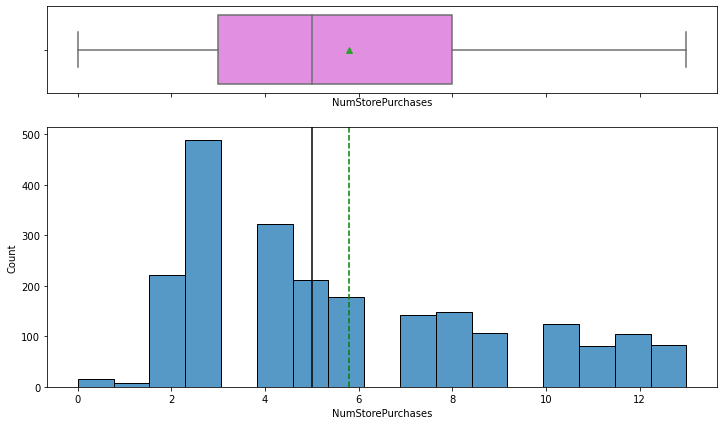

<IPython.core.display.Javascript object>

In [48]:
# observations on NumStorePurchases
histogram_boxplot(data, "NumStorePurchases")

- There are very few observations with less than 2 purchases from the store
- Most of the customers have 4 or 5 purchases from the store
- There are no outliers in this variable

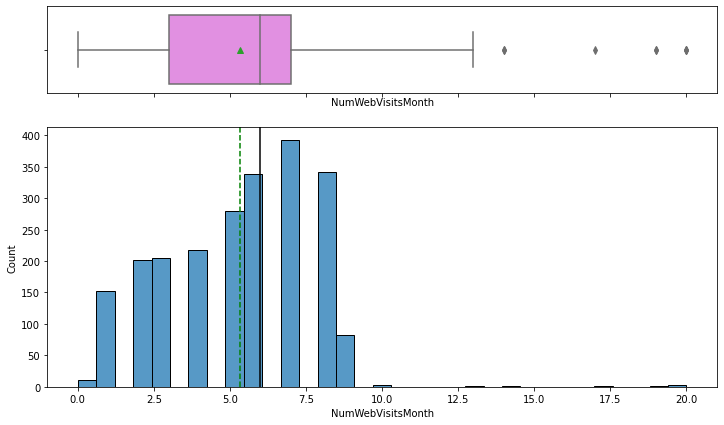

<IPython.core.display.Javascript object>

In [49]:
# observations on NumWebVisitsMonth
histogram_boxplot(data, "NumWebVisitsMonth")

- The distribution for the number of visits in a month is skewed and has some outliers at the right end.
- We will not treat this as this represents a general market trend

In [50]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

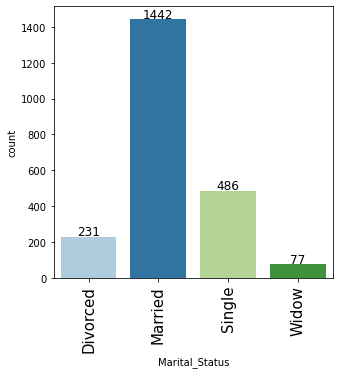

<IPython.core.display.Javascript object>

In [51]:
# observations on Marital_Status
labeled_barplot(data, "Marital_Status")

- Majority of the customers are married comprising approx 64% of total customers.

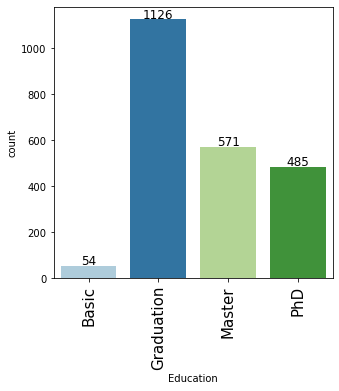

<IPython.core.display.Javascript object>

In [52]:
# observations on Education
labeled_barplot(data, "Education")

- Education of approx 50% of customers is at graduation level.
- Very few observations i.e. ~2% for customers with basic level education

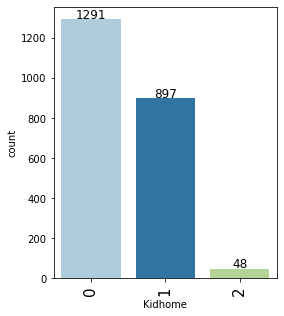

<IPython.core.display.Javascript object>

In [53]:
# observations on Kidhome
labeled_barplot(data, "Kidhome")

- ~40% of customers have 1 kid and ~58% of customers have no kids at home
- There are very few customers, approx 2%, with a number of kids greater than 1 

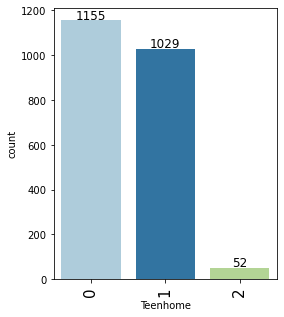

<IPython.core.display.Javascript object>

In [54]:
# observations on Teenhome
labeled_barplot(data, "Teenhome")

- Majority of the customers i.e. ~52% customers have no teen at home
- There are very few customers, only ~2%, with a number of teens greater than 1 

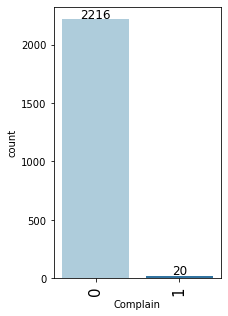

<IPython.core.display.Javascript object>

In [55]:
# observations on Complain
labeled_barplot(data, "Complain")

- Approx 99% of customers had no complaint in the last 2 years. This might be because the company provides good services or might be due to the lack of feedback options for customers.

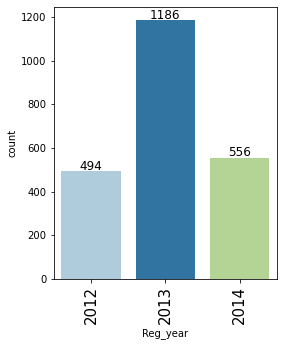

<IPython.core.display.Javascript object>

In [56]:
# observations on Registration year
labeled_barplot(data, "Reg_year")

- The number of customers registered is highest in the year 2013.

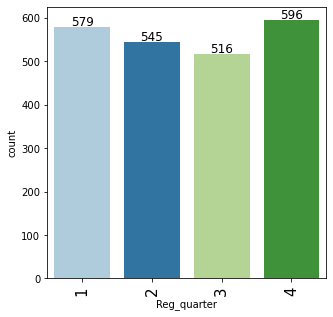

<IPython.core.display.Javascript object>

In [57]:
# observations on Registration quarter
labeled_barplot(data, "Reg_quarter")

- There is no significant difference in the number of registrations for each quarter.
- The number of registrations is slightly higher for the 1st and the 4th quarter. This can be due to the festival season in these months.
- Let's explore this further by plotting the count of registration per month.

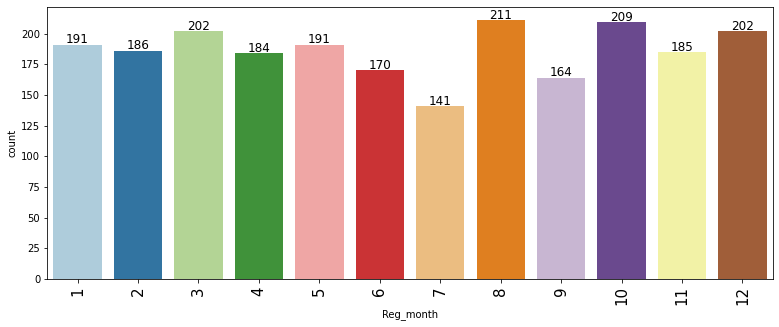

<IPython.core.display.Javascript object>

In [58]:
# observations on Registration month
labeled_barplot(data, "Reg_month")

- This shows that the highest number of registration is in the months of winters i.e. March, May, August, October.
- There is approx 3% reduction in the number of registrations from June to July.

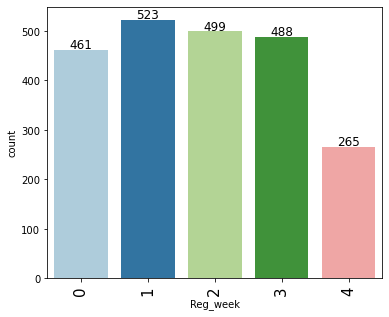

<IPython.core.display.Javascript object>

In [59]:
# observations on Registration week
labeled_barplot(data, "Reg_week")

- This shows that the number of registrations declines at the end of the month i.e. in the last two weeks.
- This can be because most people get salaries on the last day or first day of the month.

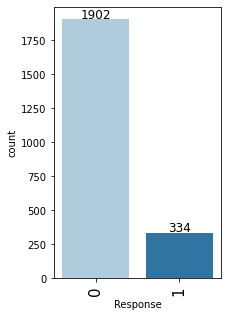

<IPython.core.display.Javascript object>

In [60]:
# observations on Response
labeled_barplot(data, "Response")

- Approx 85% customer's response was NO in the last campaign.
- This shows that the distribution of classes in the target variable is imbalanced. We have only ~15% observations where response is YES.

### Bivariate Analysis

In [ ]:
sns.pairplot(data, hue="Response")

- There are overlaps i.e. no clear distinction in the distribution of variables for people who have taken the product and did not take the product.
- Let's explore this further with the help of other plots.

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="Total_Amount_Spent", x="Marital_Status", data=data, orient="vertical")

- We can see that the total amount spent is higher for widowed customers.
- No significant difference in the amount spent by single, married or divorced customers.

In [ ]:
sns.boxplot(y="Total_Amount_Spent", x="Education", data=data, orient="vertical")

- As expected, the amount spent increases with the increase in education level.
- Customers with graduate-level education spend slightly more than customers with master-level education. 

In [ ]:
pd.pivot_table(
    data=data,
    index=["Reg_year", "Reg_month"],
    values="Total_Amount_Spent",
    aggfunc=np.sum,
).plot(kind="line", marker="o", linewidth=2)

- The plot clearly shows that the total amount spent has declined over the years.
- The plot shows the highest increase in the amount spent from August to September 2012. 

In [ ]:
sns.regplot(y=data.Total_Amount_Spent, x=data.Income)

- We can see that income and the total amount spent have a positive correlation.
- The total amount spent is not much different for customers with income in the range of 20K to 60K but the difference is significant for customers in the range of 60K to 100K.

In [ ]:
cols = data[
    [
        "MntWines",
        "MntGoldProds",
        "MntMeatProducts",
        "MntFruits",
        "MntFishProducts",
        "MntSweetProducts",
    ]
].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["Response"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Each plot shows that customer spending more on any product is more likely to take the offer. 

In [ ]:
cols = data[["Recency", "Age", "Income", "Total_Amount_Spent"]].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["Response"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Customers with lower recency i.e. less number of days since the last purchase, are more likely to take the offer.
- Response does not depend much on age.
- Customers with higher income are more likely to take the offer.
- Customers who spent more in the last 2 years are more likely to take the offer.

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
stacked_barplot(data, "Education", "Response")

- We can see a clear trend here that customers with higher education are more likely to take the offer.  

In [ ]:
stacked_barplot(data, "Marital_Status", "Response")

- We saw earlier that number of married customers is much more than single or divorced but divorced/widow customers are more likely to take the offer.
- Single customers are more likely to take the offer than married customers.

In [ ]:
stacked_barplot(data, "Kidhome", "Response")

- We can see that the number of kids increases, chances of customers taking the offer decreases.
- Customers with no kids at home are more likely to take the offer which can be expected as this includes single customers as well.

In [ ]:
stacked_barplot(data, "Teenhome", "Response")

- Customers with no teens at home are most likely to take the offer.
- Customers with two teens are more likely to take the offer than customers with 1 teenager.

In [ ]:
stacked_barplot(data, "Reg_year", "Response")

- Number of customers taking the offer is decreasing each subsequent year.
- Let's explore this further for month-wise distribution for each of the year.

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- As expected, age and year of birth have a high negative correlation. We can drop one of them.
- Registration month and quarter columns are highly correlated which can be expected as we extracted these columns from the same column.
- We can drop one of the columns in a quarter or month as they are almost perfectly correlated.
- Total amount spent is correlated with variables they are associated with and hence we can drop this column.
- Number of purchases is positively correlated with income which can be expected as customers with higher income might spend more than customers with lower income.

### Data Preparation for Modeling

In [ ]:
# Dropping birth year and Dt_Customer columns
data.drop(
    columns=[
        "Year_Birth",
        "Dt_Customer",
        "Reg_quarter",
        "Total_Amount_Spent",
    ],
    inplace=True,
)

In [ ]:
data1 = data.copy()

In [ ]:
# Separating target variable and other variables
X = data1.drop(columns="Response")
X = pd.get_dummies(X)

Y = data1["Response"]

In [ ]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=Y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

### Missing-Value Treatment

* We will use median to impute missing values in Income column.

In [ ]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_train)

X_train = impute.transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

## Building the model

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer will buy the product and the customer doesn't buy - Loss of resources
2. Predicting a customer will not buy the product and the customer buys - Loss of opportunity

#### Which case is more important? 
* Predicting that customer will not buy the product but he buys i.e. losing on a potential source of income for the company because that customer will not be targeted by the marketing team when he should be targeted.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company wants Recall to be maximized, greater the Recall lesser the chances of false negatives.

**Let's start by building different models using KFold and cross_val_score and tune the best model using GridSearchCV and RandomizedSearchCV**

- `Stratified K-Folds cross-validation` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive folds (without shuffling by default) keeping the distribution of both classes in each fold the same as the target variable. Each fold is then used once as validation while the k - 1 remaining folds form the training set.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train)) * 100
    print("{}: {}".format(name, scores))

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that Adaboost is giving the highest cross-validated recall followed by XGBoost
- The boxplot shows that the performance of xgboost is consistent with 1 outlier and with 2 one outlier for Adaboost.
- The Performance of Adaboost and XGBoost is generalised on validation set as well.
- We will tune - Adaboost and XGBoost and see if the performance improves. 

## Hyperparameter Tuning

**We will tune Adaboost and xgboost models using GridSearchCV and RandomizedSearchCV. We will also compare the performance and time taken by these two methods - grid search and randomized search.**

**First, let's create two functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Adaboost

### GridSearchCV

In [ ]:
%%time 

# defining model
model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

In [ ]:
# building model with best parameters
adb_tuned1 = AdaBoostClassifier(
    n_estimators=20,
    learning_rate=1,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)

# Fit the model on training data
adb_tuned1.fit(X_train, y_train)

In [ ]:
# Calculating different metrics on train set
Adaboost_grid_train = model_performance_classification_sklearn(
    adb_tuned1, X_train, y_train
)
print("Training performance:")
Adaboost_grid_train

In [ ]:
# Calculating different metrics on validation set
Adaboost_grid_val = model_performance_classification_sklearn(adb_tuned1, X_val, y_val)
print("Validation performance:")
Adaboost_grid_val

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(adb_tuned1, X_val, y_val)

- The validation recall is similar to cross-validated recall
- The tuned Adaboost model is  overfitting the training data
- The validation recall is still less than 50% i.e. the model is not good at identifying potential customers who would take the offer.

### RandomizedSearchCV

In [ ]:
%%time 

# defining model
model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

In [ ]:
# building model with best parameters
adb_tuned2 = AdaBoostClassifier(
    n_estimators=20,
    learning_rate=1,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)

# Fit the model on training data
adb_tuned2.fit(X_train, y_train)

In [ ]:
# Calculating different metrics on train set
Adaboost_random_train = model_performance_classification_sklearn(
    adb_tuned2, X_train, y_train
)
print("Training performance:")
Adaboost_random_train

In [ ]:
# Calculating different metrics on validation set
Adaboost_random_val = model_performance_classification_sklearn(adb_tuned2, X_val, y_val)
print("Validation performance:")
Adaboost_random_val

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(adb_tuned2, X_val, y_val)

- Grid search took a significantly longer time than random search. This difference would further increase as the number of parameters increases. 
- The results from both grid and random search are similar

## XGBoost

### GridSearchCV  

In [ ]:
%%time 

#defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in GridSearchCV
param_grid={'n_estimators':np.arange(50,150,50),
            'scale_pos_weight':[2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

In [ ]:
# building model with best parameters
xgb_tuned1 = XGBClassifier(
    random_state=1,
    n_estimators=50,
    scale_pos_weight=10,
    subsample=1,
    learning_rate=0.05,
    gamma=0,
    eval_metric="logloss",
    reg_lambda=10,
    max_depth=1,
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

In [ ]:
# Calculating different metrics on train set
xgboost_grid_train = model_performance_classification_sklearn(
    xgb_tuned1, X_train, y_train
)
print("Training performance:")
xgboost_grid_train

In [ ]:
# Calculating different metrics on validation set
xgboost_grid_val = model_performance_classification_sklearn(xgb_tuned1, X_val, y_val)
print("Validation performance:")
xgboost_grid_val

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_val, y_val)

- The validation recall has increased by ~54% as compared to the result from cross-validation with default parameters.
- The model has very low precision score (however low precision shouldn't affect us much here)

### RandomizedSearchCV

In [ ]:
%%time

# defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={'n_estimators':np.arange(50,150,50),
            'scale_pos_weight':[2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
xgb_tuned2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned2.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned2.best_params_,xgb_tuned2.best_score_))

In [ ]:
# building model with best parameters
xgb_tuned2 = XGBClassifier(
    random_state=1,
    n_estimators=50,
    scale_pos_weight=10,
    gamma=1,
    subsample=0.9,
    learning_rate=0.1,
    eval_metric="logloss",
    max_depth=1,
    reg_lambda=10,
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

In [ ]:
# Calculating different metrics on train set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned2, X_train, y_train
)
print("Training performance:")
xgboost_random_train

In [ ]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned2, X_val, y_val)
print("Validation performance:")
xgboost_random_val

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned2, X_val, y_val)

- The parameters obtained from both grid search and random search are approximately same
- The performance of both the models is also very similar
- Tuning with grid search took a significantly longer time

## Comparing all models

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        Adaboost_grid_train.T,
        Adaboost_random_train.T,
        xgboost_grid_train.T,
        xgboost_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost Tuned with Grid search",
    "AdaBoost Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        Adaboost_grid_val.T,
        Adaboost_random_val.T,
        xgboost_grid_val.T,
        xgboost_random_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "AdaBoost Tuned with Grid search",
    "AdaBoost Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

- The xgboost model tuned using Grid search is giving the best validation recall of 0.95 but it has the low values of train and validation precision.
- Let's check the model's performance on test set and then see the feature importance from the tuned xgboost model

#### Performance on the test set

In [ ]:
# Calculating different metrics on the test set
xgboost_grid_test = model_performance_classification_sklearn(xgb_tuned1, X_test, y_test)
print("Test performance:")
xgboost_grid_test

- The performance on test data is generalised

In [ ]:
feature_names = X.columns
importances = xgb_tuned1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Amount spent on gold products is the most important feature, followed by Teenhome and NumCatalogPurchases.

## Pipelines for productionizing the model
- Now, we have a final model. let's use pipelines to put the model into production



## Column Transformer
- We know that we can use pipelines to standardize the model building, but the steps in a pipeline are applied to each and every variable - how can we personalize the pipeline to perform different processing on different columns
- Column transformer allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

- We will create 2 different pipelines, one for numerical columns and one for categorical columns
- For numerical columns, we will do missing value imputation as pre-processing
- For categorical columns, we will do one hot encoding and missing value imputation as pre-processing

- We are doing missing value imputation for the whole data, so that if there is any missing value in the data in future that can be taken care of.

In [ ]:
# creating a list of numerical variables
numerical_features = [
    "Income",
    "Kidhome",
    "Teenhome",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
    "Complain",
    "Age",
    "Reg_year",
    "Reg_month",
    "Reg_week",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


# creating a list of categorical variables
categorical_features = ["Education", "Marital_Status"]

# creating a transformer for categorical variables, which will first apply simple imputer and 
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data 
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes


In [ ]:
# Separating target variable and other variables
X = data1.drop(columns="Response")
Y = data1["Response"]

- Now we already know the best model we need to process with, so we don't need to divide data into 3 parts

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

In [ ]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=50,
                scale_pos_weight=10,
                subsample=1,
                learning_rate=0.05,
                gamma=0,
                eval_metric="logloss",
                reg_lambda=10,
                max_depth=1,
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

## Business Recommendations

- Company should target customers who buy premium products - gold products or high-quality wines - as these customers can spend more and are more likely to purchase the offer. The company should further launch premium offers for such customers. Such offers can also be extended to customers with higher income. 
- We observed in our analysis that ~64% of customers are married but single customers, including divorced and widowed, are more equally or more likely to take the offer. The company should expand its customers by customizing offers to attract more single customers.
- Customers who are frequent buyers, should be targeted more by the company and offer them added benefits.
- Total amount spent has decreased over the years which shows that either our product qualities have declined or the company lacks marketing strategies. The company should constantly improve its marketing strategies to address such issues.
- Our analysis showed that ~99% of customers had no complaints in the last two years which can be due to the lack of feedback options for customers. The company should create easy mechanisms to gather feedback from the customers and use it to identify major concerns if any.
- The number of web visits is an important feature and the company should work on customizing its website to allow more traffic on the website. The company can improve the interface and provide easy check-in, check-out and delivery options.